In [1]:
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import xarray as xr
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmoocean as cmo
import warnings
warnings.filterwarnings('ignore')
from wim_dateTime import createListDateTime
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
import os
import glob
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm



def convertEgg2Num_FSD(fsd_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=fsd_egg.where(fsd_egg<99).values
    sic_num[sic_num==22]=1.65
    sic_num[sic_num==1]=1
    sic_num[sic_num==2]=10
    sic_num[sic_num==3]=60
    sic_num[sic_num==4]=300
    sic_num[sic_num==5]=1250
    sic_num[sic_num==6]=6000
    sic_num[sic_num==7]=15000
    sic_num[sic_num==8]=np.nan
    sic_num[sic_num==9]=0
    sic_num[sic_num==10]=0
    sic_num[sic_num==21]=15000
    return sic_num.astype(float)

def convertEgg2Num_SIC(sic_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=sic_egg.where(sic_egg<99).values
    sic_num[sic_num==92]=10
    sic_num[sic_num==91]=9.5
    sic_num[sic_num==90]=9
    sic_num[sic_num==89]=8.5
    sic_num[sic_num==81]=9
    sic_num[sic_num==80]=8
    sic_num[sic_num==79]=8
    sic_num[sic_num==78]=7.5
    sic_num[sic_num==70]=7
    sic_num[sic_num==68]=7
    sic_num[sic_num==67]=6.5
    sic_num[sic_num==57]=6
    sic_num[sic_num==56]=5.5
    sic_num[sic_num==46]=5
    sic_num[sic_num==45]=4.5
    sic_num[sic_num==35]=4
    sic_num[sic_num==34]=3.5
    sic_num[sic_num==24]=3
    sic_num[sic_num==23]=2.5
    sic_num[sic_num==13]=2
    sic_num[sic_num==12]=1.5
    sic_num[sic_num==60]=6
    sic_num[sic_num==50]=5
    sic_num[sic_num==40]=4
    sic_num[sic_num==30]=3
    sic_num[sic_num==20]=2
    sic_num[sic_num==10]=1
    sic_num[sic_num==98]=0
    sic_num[sic_num==2]=0.1
    sic_num[sic_num==1]=0.1
    sic_num[sic_num<=0]=0

    return sic_num.astype(float)/10

def convertEgg2Num_ITD(sic_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=sic_egg.where(sic_egg<99).values
    sic_num[sic_num==80]=0
    sic_num[sic_num==90]=np.nan
    sic_num[sic_num==92]=np.nan
    sic_num[sic_num==98]=0
    sic_num[sic_num==81]=5
    sic_num[sic_num==82]=5
    sic_num[sic_num==83]=20
    sic_num[sic_num==84]=12.5
    sic_num[sic_num==85]=22.5
    sic_num[sic_num==87]=50
    sic_num[sic_num==88]=40
    sic_num[sic_num==89]=60
    sic_num[sic_num==91]=95
    sic_num[sic_num==93]=200
    sic_num[sic_num==94]=150
    sic_num[sic_num==95]=300
    sic_num[sic_num==96]=250
    sic_num[sic_num==97]=350
    
    return sic_num.astype(float)



def readCryoSat2(list_file_N7, list_file_C2):

    grid_NSIDC='/storage/bward/obs/nsidc/NSIDC0771_CellArea_PS_N25km_v1.0.nc'
    dx_NSIDC=xr.open_dataset(grid_NSIDC)
    dx_NSIDC=dx_NSIDC.cell_area
    coord_obs="/storage/bward/obs/nsidc/NSIDC0771_LatLon_PS_N25km_v1.0.nc"
    dx_coord_obs=xr.open_dataset(coord_obs)
    lat_obs=dx_coord_obs.latitude
    lon_obs=dx_coord_obs.longitude
    # mask_lab= np.logical_or(lon_obs<=-75, lon_obs>=-43)
    # mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)
    mask_lab= np.logical_or(lon_obs<=-65, lon_obs>=-43)
    mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)
    mask_SL = np.logical_and.reduce((
    lon_obs >= -75,
    lon_obs <= -57,
    lat_obs >= 45,
    lat_obs <= 51
    ))
    
    listN7=[]
    listC2=[]
    aice1d=np.array([])
    fsd1d=np.array([])
    indexF=0
    for file_N7 in list_file_N7:
        fileC2=list_file_C2[indexF]
        dx_obs_fsd=np.squeeze(xr.open_dataset(fileC2))
        dx_obs=np.squeeze(xr.open_dataset(file_N7))
        tempN7=np.squeeze(dx_obs.F17_ICECON) 
        listN7.append(tempN7)
        tempC2=np.squeeze(dx_obs_fsd.fsdrad)*2
        listC2.append(tempC2)
        
        mask_1 = np.logical_or(tempN7.values > 1, tempN7.values < 0.15)
        mask_3 = np.logical_or(tempN7.values > 1, tempN7.values > 0.8)
        mask_4 = np.logical_or(tempN7.values > 1, tempN7.values > 0.9)
        mask_2 = np.logical_or(tempC2>300, tempC2==300)   

        test_FSD = ma.masked_array(np.nan_to_num(tempC2), mask=mask_1+mask_3+mask_lab+mask_lab2+mask_SL)
        test_SIC = ma.masked_array(tempN7, mask=mask_1+mask_3+mask_lab+mask_lab2+mask_SL)
        
        fsd_nan=test_FSD[~np.isnan(test_FSD)]
        sic_nan=test_SIC[~np.isnan(test_FSD)]

        fsd_mask=fsd_nan[~fsd_nan.mask]
        sic_mask=sic_nan[~fsd_nan.mask]
        
        aice1d=np.append(aice1d,np.squeeze(sic_mask))
        fsd1d=np.append(fsd1d,np.squeeze(fsd_mask))

    
# #         area_fsd_y = ma.masked_array(dx_NSIDC.values, mask=mask_1+mask_2+mask_lab+mask_lab2+mask_4)
# #         area_aice_y = ma.masked_array(dx_NSIDC.values, mask=mask_1+mask_3+mask_lab+mask_lab2)
        
        
#         indexF=indexF+1
        
# #     avg_aice_obs=np.nanmean(np.stack(listN7),axis=0)
# #     avg_fsd_obs=np.nanmean(np.stack(listC2),axis=0)
    
# #     avg_fsd_obs[avg_fsd_obs<=0]=np.nan
    
    return [aice1d, fsd1d]


def readIceChartfiles(list_files):
    
    grid_IC='/storage/bward/obs/iceChart/depot.cmc.ec.gc.ca/upload/mrb/caya/area.nc'
    dx_IC=xr.open_dataset(grid_IC)
    dx_IC=dx_IC.AREA
    lat_IC=dx_IC.lat
    lon_IC=dx_IC.lon
    mask_labIC=np.logical_or(lon_IC<=-65, lon_IC>=-43)
    mask_lab2IC=np.logical_or(lat_IC<=45, lat_IC>=72)
    
    listFA=[]
    listFB=[]
    listFC=[]

    listSA=[]
    listSB=[]
    listSC=[]

    listCA=[]
    listCB=[]
    listCC=[]
    listCT=[]

    stdCT=[]
    stdFSD=[]
    for file_IC in list_files:
#         print(file_IC)
        ds_temp=xr.open_dataset(file_IC)

        temp_FA=convertEgg2Num_FSD(np.squeeze(ds_temp.FA))
        temp_FB=convertEgg2Num_FSD(np.squeeze(ds_temp.FB))
        temp_FC=convertEgg2Num_FSD(np.squeeze(ds_temp.FC))
        temp_SA=convertEgg2Num_ITD(np.squeeze(ds_temp.SA))
        temp_SB=convertEgg2Num_ITD(np.squeeze(ds_temp.SB))
        temp_SC=convertEgg2Num_ITD(np.squeeze(ds_temp.SC))
        temp_CA=convertEgg2Num_SIC(np.squeeze(ds_temp.CA))
        temp_CB=convertEgg2Num_SIC(np.squeeze(ds_temp.CB))
        temp_CC=convertEgg2Num_SIC(np.squeeze(ds_temp.CC))
        temp_CT=convertEgg2Num_SIC(np.squeeze(ds_temp.CT))
        
#         temp_SIC=temp_CA+temp_CB+temp_CC
#         temp_SIC[temp_SIC<=0]=np.nan
#         temp_FSD=(temp_CA/temp_SIC)*temp_FA+(temp_CB/temp_SIC)*temp_FB+(temp_CC/temp_SIC)*temp_FC
        
#         mask_IC1 = np.logical_or(np.isnan(temp_CT), temp_CT<0.15)
#         mask_IC2 = np.logical_or(temp_FSD<0, temp_FSD>300)
#         mask_IC3 = np.logical_or(temp_CT>1, temp_CT>0.8)
#         mask_IC4 = np.logical_or(temp_CT>1, temp_CT>0.9)
# #         mask_IC5 = np.logical_or(temp_CT<0, FSD<-10)
    
#         area_fsd_y = ma.masked_array(dx_IC.values, mask=mask_IC1+mask_IC2+mask_labIC+mask_lab2IC+mask_IC4)
#         area_aice_y = ma.masked_array(dx_IC.values, mask=mask_IC1+mask_IC3+mask_labIC+mask_lab2IC)
    
#         stdCT.append(np.sum(np.sum(area_aice_y, axis=0))/1e6)
#         stdFSD.append(np.sum(np.sum(area_fsd_y, axis=0))/1e6)
        
        listFA.append(temp_FA)
        listFB.append(temp_FB)
        listFC.append(temp_FC)
        listSA.append(temp_SA)
        listSB.append(temp_SB)
        listSC.append(temp_SC)
        listCA.append(temp_CA)
        listCB.append(temp_CB)
        listCC.append(temp_CC)
        listCT.append(temp_CT)
        

    #     FSDA=np.stack((FSDA, convertEgg2Num_FSD(np.squeeze(ds_temp.FA)).reshape((lon.shape[0], lon.shape[1], 1))))
    FSDA=np.nanmean(np.stack(listFA),axis=0)
    FSDB=np.nanmean(np.stack(listFB),axis=0)
    FSDC=np.nanmean(np.stack(listFC),axis=0)

    ITDA=np.nanmean(np.stack(listSA),axis=0)
    ITDB=np.nanmean(np.stack(listSB),axis=0)
    ITDC=np.nanmean(np.stack(listSC),axis=0)

    SICA=np.nanmean(np.stack(listCA),axis=0)
    SICB=np.nanmean(np.stack(listCB),axis=0)
    SICC=np.nanmean(np.stack(listCC),axis=0)
    SICT=np.nanmean(np.stack(listCT),axis=0)

    SIC=SICA+SICB+SICC
    SIC[SIC<=0]=np.nan

    FSD=(SICA/SIC)*FSDA+(SICB/SIC)*FSDB+(SICC/SIC)*FSDC
    
    
    mask1 = np.logical_or(np.isnan(SICT), SICT<0.15)
    mask2 = np.logical_or(FSD<0, FSD>300)
    mask3 = np.logical_or(SICT>1, SICT>0.8)
    mask4 = np.logical_or(SICT>1, SICT>0.9)
    mask5 = np.logical_or(FSD<0, FSD<-10)
        
    mask_SL = np.logical_and.reduce((
    lon_IC >= -75,
    lon_IC <= -57,
    lat_IC >= 45,
    lat_IC <= 51
    ))

    test_FSD = ma.masked_array(FSD, mask=mask1+mask3+mask_labIC+mask_lab2IC+mask5+mask_SL)
    test_SIC = ma.masked_array(SICT, mask=mask1+mask3+mask_labIC+mask_lab2IC+mask_SL)

    fsd_1d=np.squeeze(test_FSD.reshape((test_FSD.shape[0]*test_FSD.shape[1],1)))
    sic_1d=np.squeeze(test_SIC.reshape((test_FSD.shape[0]*test_FSD.shape[1],1)))
    
    fsd_nan=fsd_1d[~np.isnan(fsd_1d)]
    sic_nan=sic_1d[~np.isnan(fsd_1d)]

    fsd_mask=fsd_nan[~fsd_nan.mask]
    sic_mask=sic_nan[~fsd_nan.mask]
    
    return [sic_mask, fsd_mask]



In [2]:
REP_coup='/aos/home/bward/wim/post-proc/case83/avg/'
REP_IC2='/aos/home/bward/wim/post-proc/case89/avg/'
path_obs="/storage/bward/obs/nsidc/raw/"
path_obs_fsd='/storage/bward/obs/cryoSat2/nsidc/'
path_IC='/storage/bward/obs/iceChart/CIS_10km/'
monthsl=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
list_month=[1,2,3,4] #,4,5,6,7,8,9,10,11,12]
# monthsl=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

file_area='/aos/home/bward/wim/cice/out/case74/history/iceh_ic.2005-01-09-43200.nc'
dx_area = xr.open_dataset(file_area)
dx_area= dx_area.tarea

grid_NSIDC='/storage/bward/obs/nsidc/NSIDC0771_CellArea_PS_N25km_v1.0.nc'
dx_NSIDC=xr.open_dataset(grid_NSIDC)
dx_NSIDC=dx_NSIDC.cell_area
coord_obs="/storage/bward/obs/nsidc/NSIDC0771_LatLon_PS_N25km_v1.0.nc"
dx_coord_obs=xr.open_dataset(coord_obs)
lat_obs=dx_coord_obs.latitude
lon_obs=dx_coord_obs.longitude
# mask_lab= np.logical_or(lon_obs<=-75, lon_obs>=-43)
# mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)
mask_lab= np.logical_or(lon_obs<=-65, lon_obs>=-43)
mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)
    
grid_IC='/storage/bward/obs/iceChart/depot.cmc.ec.gc.ca/upload/mrb/caya/area.nc'
dx_IC=xr.open_dataset(grid_IC)
dx_IC=dx_IC.AREA
lat_IC=dx_IC.lat
lon_IC=dx_IC.lon
mask_labIC=np.logical_or(lon_IC<=-65, lon_IC>=-43)
mask_lab2IC=np.logical_or(lat_IC<=45, lat_IC>=72)

list_year=[2010,2011,2012,2013,2014,2015,2016,2017,2018]


fsd_C2=np.array([])
sic_C2=np.array([])

fsd_IC=np.array([])
sic_IC=np.array([])

fsd_model=np.array([])
sic_model=np.array([])
           
for yyyy in list_year:
    for mm in list_month:
        list_file_IC=[]
        list_file_N7=[]
        list_file_C2=[]
        if ( yyyy == 2018 ):
            if mm != 12:
                nameFile='iceh_avg.2018'+str(mm).zfill(2)+'0100000-2018'+str(mm+1).zfill(2)+'0100000.nc'
            else:
                nameFile='iceh_avg.2018'+str(mm).zfill(2)+'0100000-2019010100000.nc'
    
            #Read model and create mask
            pathFile_coup=REP_coup+nameFile
            dx_coup = xr.open_dataset(pathFile_coup)
            lat=dx_coup.TLAT
            lon=dx_coup.TLON

#             aice=np.squeeze(dx_coup.aice)
#             fsd=np.squeeze(dx_coup.fsdrad)

#             maskLab=aice.where(np.logical_and(np.logical_and(lat>=45, lat<=72), np.logical_and(lon>=360-65, lon<=360-43)))
#             aice_mod1d=np.squeeze(aice.where(np.logical_and(maskLab>=0.15, maskLab<=0.8)).values.reshape((aice.shape[0]*aice.shape[1],1)))
#             fsd_mod1d=np.squeeze(fsd.where(np.logical_and(maskLab>=0.15, maskLab<=0.8)).values.reshape((fsd.shape[0]*fsd.shape[1],1)))

#             aice_mod1d=aice_mod1d[~np.isnan(aice_mod1d)]
#             fsd_mod1d=fsd_mod1d[~np.isnan(fsd_mod1d)]

#             sic_model=np.append(sic_model,aice_mod1d)
#             fsd_model=np.append(fsd_model,fsd_mod1d)
    
#         #Create a list of file to read for each dataset
#         file_pattern_N7="NSIDC0051_SEAICE_PS_N25km_"+str(yyyy)+str(mm).zfill(2)+"_v2.0.nc"
#         filePath_N7=os.path.join(path_obs, file_pattern_N7)
#         tempFileN7=glob.glob(filePath_N7)
        
#         file_pattern_C2="cryosat_fsd_"+str(yyyy)+str(mm).zfill(2)+"_nsidc.nc"
#         filePath_C2=os.path.join(path_obs_fsd, file_pattern_C2)
#         tempFileC2=glob.glob(filePath_C2)
        
#         file_pattern_IC='CIS_10km_'+str(yyyy)+str(mm).zfill(2)+'*'+'.nc'
#         filePath_IC=os.path.join(path_IC, file_pattern_IC)
#         tempFileL=glob.glob(filePath_IC)
        
#         for f in tempFileL:
#             list_file_IC.append(f)
            
#         for fN7 in tempFileN7:
#             list_file_N7.append(fN7)
            
#         for fC2 in tempFileC2:
#             list_file_C2.append(fC2)
        
#         IC_data=readIceChartfiles(list_file_IC) 
#         FSD=IC_data[1]
#         SICT=IC_data[0]
        
#         fsd_IC=np.append(fsd_IC,FSD)
#         sic_IC=np.append(sic_IC,SICT)
        
#         #Nimbus-7000 stuff
#         obs_data=readCryoSat2(list_file_N7, list_file_C2) 
#         sic_1d=obs_data[0]
#         fsd_1d=obs_data[1]
    
#         fsd_C2=np.append(fsd_C2,fsd_1d)
#         sic_C2=np.append(sic_C2,sic_1d)
        
    
# fsd1=[0, 10, 30, 60, 100, 200, 300, 400, 600, 900, 1200, 1500, 2000]
# fsdC2=[0, 30, 60, 100, 200, 300, 400, 600, 900, 1200, 1500, 2000]
# fsd_cat = [x*10 for x in fsd1]
# fsd_catC2 = [x*10 for x in fsdC2]

# hist_IC=np.zeros(len(fsd_cat)-1)
# hist_C2=np.zeros(len(fsd_catC2)-1)
# temp_C2=np.zeros(len(fsd_catC2)-1)
# hist_model=np.zeros(len(fsd_cat)-1)
# binCenter=[]
# binSpread=[] 
# binCenterC2=[]
# binSpreadC2=[]

# # for b in range(len(fsd_catC2)-1):
# #     binCenterC2.append((fsd_catC2[b]+fsd_catC2[b+1])/2)
# #     binSpreadC2.append(fsd_catC2[b+1]-fsd_catC2[b])
        
# for ncat in range(len(fsd_cat)-1):
#     binCenter.append((fsd_cat[ncat]+fsd_cat[ncat+1])/2)
#     binSpread.append(fsd_cat[ncat+1]-fsd_cat[ncat])
#     lower_bound=fsd_cat[ncat]
#     upper_bound=fsd_cat[ncat+1]
#     count_fsd_IC=fsd_IC[np.logical_and(fsd_IC>=lower_bound, fsd_IC<upper_bound)]
#     hist_IC[ncat]=len(count_fsd_IC)
#     count_model=fsd_model[np.logical_and(fsd_model>lower_bound, fsd_model<=upper_bound)]
#     hist_model[ncat]=len(count_model)
    
# for ncat2 in range(len(fsd_catC2)-1):
#     binCenterC2.append((fsd_catC2[ncat2]+fsd_catC2[ncat2+1])/2)
#     binSpreadC2.append(fsd_catC2[ncat2+1]-fsd_catC2[ncat2])
#     lower_bound2=fsd_catC2[ncat2]
#     upper_bound2=fsd_catC2[ncat2+1]
#     count_fsd_C2=fsd_C2[np.logical_and(fsd_C2>=lower_bound2, fsd_C2<upper_bound2)]
#     hist_C2[ncat2]=len(count_fsd_C2)
#     temp_C2[ncat2]=len(count_fsd_C2)
        
# # for ncat in range(len(fsd_catC2)-1):
# #     if ncat < len(fsd_catC2)-1:
# #         lower_bound=fsd_catC2[ncat]
# #         upper_bound=fsd_catC2[ncat+1]
        
# #         count_fsd_C2=fsd_C2[np.logical_and(fsd_C2>lower_bound, fsd_C2<=upper_bound)]
# #         hist_C2[ncat]=len(count_fsd_C2)
# #     else:
# #         lower_bound=fsd_cat[ncat]
# #         upper_bound=np.Inf
# test=int(np.sum(hist_C2))
# test2=int(np.sum(hist_IC))
# test3=int(np.sum(hist_model))

# temp_C2[0]=np.nan
# fracC2=temp_C2/np.sum(hist_C2)*100
# fracMod=hist_model/np.sum(hist_model)*100

# # temp[0]=0
# # plt.savefig('hist_FSD_cMIZ_obs_model',dpi='figure',format='png',metadata=None)

In [3]:
# from matplotlib.gridspec import GridSpec

# fig = plt.figure(figsize=[14, 6])
# fig.subplots_adjust(left=0.075, right=0.98, bottom=0.1, top=0.95) 
# gs = GridSpec(1,2,figure=fig, hspace=0.1, wspace=0.1, width_ratios=[1, 1])

# # Set the colormap
# colours_high=["#ff5a5f", "#c81d25"]
# colours_low=["#2196f3", "#bbdefb"]

# cmap_1 = mpl.colors.LinearSegmentedColormap.from_list("map0", colours_high, N=256)
# norm_1=mpl.colors.Normalize(0.7, 1)

# cmap_2 = mpl.colors.LinearSegmentedColormap.from_list("map1", colours_low, N=256)
# norm_2=mpl.colors.Normalize(0, 0.3)
# # axes.plot(np.array(binCenterC2), hist_C2/np.sum(hist_C2)*100, label= 'Cryo-2', linewidth=3)
# # axes.plot(np.array(binCenter), hist_model/np.sum(hist_model)*100, label= 'CTRL',linewidth=3)
# # axes.plot(np.array(binCenter), hist_IC/np.sum(hist_IC)*100, label='CIS', linewidth=3)
# patate=[0, binCenter[0]+binSpread[0]/2, binCenter[1]+binSpread[1]/2, binCenter[2]+binSpread[2]/2, binCenter[3]+binSpread[3]/2, binCenter[4]+binSpread[4]/2, binCenter[5]+binSpread[5]/2,binCenter[6]+binSpread[6]/2,binCenter[7]+binSpread[7]/2,binCenter[8]+binSpread[8]/2,binCenter[9]+binSpread[9]/2,binCenter[10]+binSpread[10]/2]

# axes = fig.add_subplot(gs[0, 0])
# plt.sca(axes)

# axes.step(patate,hist_IC/np.sum(hist_IC)*100, where='post', color='k', linewidth=3, zorder=4,linestyle='--')
# bar1=axes.bar(np.array(binCenterC2), temp_C2/np.sum(hist_C2)*100, width = np.array(binSpreadC2), edgecolor='black')
# # axes.bar_label(bar1, labels=[f'{e:,.1f}' for e in fracC2], padding=3, color='black', fontsize=16)

# # axes.step(np.array(binCenter),hist_IC/np.sum(hist_IC)*100,'k', where='mid',linewidth=3, linestyle='--')
# # axes.bar(np.array(binCenter), hist_IC/np.sum(hist_IC)*100, width = np.array(binSpread), label='CIS', edgecolor='black',alpha=0.5)
# # axes.bar(np.array(binCenter)+np.array(binSpread)/4, hist_model/np.sum(hist_model)*100, width = np.array(binSpread)/2, label= 'CTRL', edgecolor='black')
# axes.set_xscale('log')
# axes.set_ylim([0,100])
# plt.axvline(x=300, color='r', linestyle='-', linewidth=3)
# axes.set_ylabel("MIZ-SIC fraction [%]", size=24)
# axes.set_title('a)', loc='left', fontsize=22)

# axes.text(0.55, 0.1, "CIS", transform=axes.transAxes, color='k', fontsize=20,ha='right', va='bottom')
# axes.text(1.38, -0.13, "Mean floe diameter [m]", transform=axes.transAxes, color='k', fontsize=24,ha='right', va='bottom')

# # axes.text(0.225, 0.07, "MIZ-FSD", transform=axes.transAxes, color='red', fontsize=20,ha='right', va='bottom')

# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
# axes.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)

# axes = fig.add_subplot(gs[0, 1])
# plt.sca(axes)
# axes.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
# axes.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
# axes.set_title('b)', loc='left', fontsize=22)

# axes.step(patate,hist_IC/np.sum(hist_IC)*100, where='post', color='k', linewidth=3, zorder=6,linestyle='--')
# bar1=axes.bar(np.array(binCenter), fracMod, width = np.array(binSpread), edgecolor='black',zorder=6)
# # axes.bar_label(bar1, labels=[f'{e:,.1f}' for e in fracC2], padding=3, color='black', fontsize=16)

# # axes.step(np.array(binCenter),hist_IC/np.sum(hist_IC)*100,'k', where='mid',linewidth=3, linestyle='--')
# # axes.bar(np.array(binCenter), hist_IC/np.sum(hist_IC)*100, width = np.array(binSpread), label='CIS', edgecolor='black',alpha=0.5)
# # axes.bar(np.array(binCenter)+np.array(binSpread)/4, hist_model/np.sum(hist_model)*100, width = np.array(binSpread)/2, label= 'CTRL', edgecolor='black')
# axes.set_xscale('log')
# axes.set_ylim([0,100])
# plt.axvline(x=300, color='r', linestyle='-', linewidth=3)
# axes.text(0.55, 0.1, "CIS", transform=axes.transAxes, color='k', fontsize=20,ha='right', va='bottom')
# axes.set_yticklabels([])
# # axes.text(0.225, 0.07, "MIZ-FSD", transform=axes.transAxes, color='red', fontsize=20,ha='right', va='bottom')

# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

# plt.savefig('fsd_sic-miz_cryo2_model_CIS.png',dpi='figure',format='png',metadata=None)


No handles with labels found to put in legend.


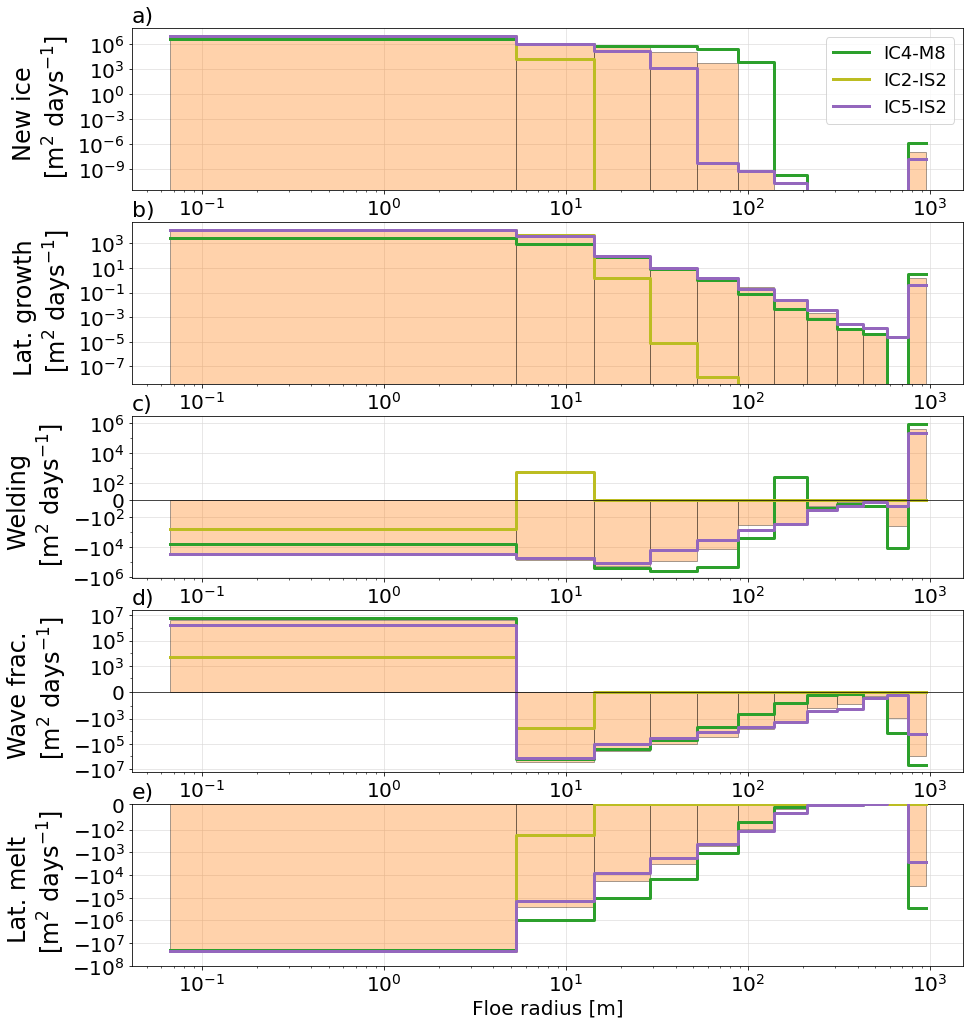

In [4]:
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

file_area='/aos/home/bward/wim/cice/out/case74/history/iceh_ic.2005-01-09-43200.nc'
dx_area = xr.open_dataset(file_area)
dx_area= dx_area.tarea

binFSD=[6.65000000*10**-2,   5.31030847,   1.42865861*10**1,   2.90576686*10**1, 5.24122136*10**1,   8.78691405*10**1,   1.39518470*10**2, 2.11635752*10**2, 3.08037274*10**2, 4.31203059*10**2, 5.81277225*10**2, 7.55141047*10**2, 9.45812834*10**2]
binCenter=[]
binSpread=[]
for b in range(len(binFSD)-1):
    binCenter.append((binFSD[b]+binFSD[b+1])/2)
    binSpread.append(binFSD[b+1]-binFSD[b])
    
# binCenterC=[binCenter[0]-binSpread[0]/2, binCenter[0]+binSpread[0]/2, binCenter[1]+binSpread[1]/2, binCenter[2]+binSpread[2]/2, binCenter[3]+binSpread[3]/2, binCenter[4]+binSpread[4]/2, binCenter[5]+binSpread[5]/2,binCenter[6]+binSpread[6]/2,binCenter[7]+binSpread[7]/2,binCenter[8]+binSpread[8]/2,binCenter[9]+binSpread[9]/2,binCenter[10]+binSpread[10]/2, binCenter[11]+binSpread[11]/2]
binCenterC=[binCenter[0]-binSpread[0]/2, binCenter[0]+binSpread[0]/2, binCenter[1]+binSpread[1]/2, binCenter[2]+binSpread[2]/2, binCenter[3]+binSpread[3]/2, binCenter[4]+binSpread[4]/2, binCenter[5]+binSpread[5]/2,binCenter[6]+binSpread[6]/2,binCenter[7]+binSpread[7]/2,binCenter[8]+binSpread[8]/2,binCenter[9]+binSpread[9]/2,binCenter[10]+binSpread[10]/2, binCenter[11]+binSpread[11]/2]

year=2018
mm=3

# repC='/aos/home/bward/wim/cice/out/case83/history/'
# nameFileC='iceh_avg.'+str(year)+'-'+str(mm).zfill(2)+'.nc'

# pathFileC=repC+nameFileC
# dxC= xr.open_dataset(pathFileC)
# lat=dxC.TLAT.values
# lon=dxC.TLON.values
# aiceC=np.squeeze(dxC.aice)
# newiC=np.squeeze(dxC.dafsd_newi)
# weldC=np.squeeze(dxC.dafsd_weld)
# latmC=np.squeeze(dxC.dafsd_latm)
# latgC=np.squeeze(dxC.dafsd_latg)
# waveC=np.squeeze(dxC.dafsd_wave)

# maskLabC=aiceC.where(np.logical_and(np.logical_and(lat>=45, lat<=72), np.logical_and(lon>=360-65, lon<=360-43)))
# maskLab3DC=np.repeat(maskLabC.values[np.newaxis, :, :], 12, axis=0)
# maskcMIZC=aiceC.where(aiceC>=0.15)
# maskPackC=aiceC.where(aiceC>0.8)
# maskcMIZ3DC=np.repeat(maskcMIZC.values[np.newaxis, :, :], 12, axis=0)
# maskPack3DC=np.repeat(maskPackC.values[np.newaxis, :, :], 12, axis=0)

# newi_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(newiC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# newi_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(newiC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# latg_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latgC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# latg_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latgC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# weld_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(weldC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# weld_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(weldC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# latm_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latmC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# latm_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latmC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# wave_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(waveC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# wave_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(waveC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# test=np.insert(newi_cMIZC, 0, newi_cMIZC[0], axis=0)
list_cases=['case83', 'case95', 'case89', 'case96']
list_color=['tab:orange', 'tab:green', 'tab:olive', 'tab:purple']
list_label=['IC4-M3 (CTRL)', 'IC4-M8', 'IC2-IS2', 'IC5-IS2']
list_linestyle=['solid', '--', ':', 'dashdot']

fig = plt.figure(figsize=[14, 14])
fig.subplots_adjust(left=0.15, right=0.975, bottom=0.05, top=0.98) 
gs = GridSpec(5,1,figure=fig, hspace=0.2, wspace=0.15, width_ratios=[1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])
ax5 = fig.add_subplot(gs[4, 0])



index=0
for case in list_cases:
    rep='/aos/home/bward/wim/cice/out/'+case+'/history/'
    nameFile='iceh_avg.'+str(year)+'-'+str(mm).zfill(2)+'.nc'
    
    pathFile=rep+nameFile
    dx= xr.open_dataset(pathFile)
    aice=np.squeeze(dx.aice)
    newi=np.squeeze(dx.dafsd_newi)
    weld=np.squeeze(dx.dafsd_weld)
    latm=np.squeeze(dx.dafsd_latm)
    latg=np.squeeze(dx.dafsd_latg)
    wave=np.squeeze(dx.dafsd_wave)
    maskLab=aice.where(np.logical_and(np.logical_and(lat>=45, lat<=72), np.logical_and(lon>=360-65, lon<=360-43)))
    maskLab3D=np.repeat(maskLab.values[np.newaxis, :, :], 12, axis=0)
    maskcMIZ=aice.where(aice>=0.15)
    maskPack=aice.where(aice>0.8)
    maskcMIZ3D=np.repeat(maskcMIZ.values[np.newaxis, :, :], 12, axis=0)
    maskPack3D=np.repeat(maskPack.values[np.newaxis, :, :], 12, axis=0)
    
    newi_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(newi.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
    newi_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(newi.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

    latg_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latg.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
    latg_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latg.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

    weld_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(weld.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
    weld_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(weld.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

    latm_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latm.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
    latm_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latm.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

    wave_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(wave.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
    wave_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(wave.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

    test_newi=np.insert(newi_cMIZ, 1, newi_cMIZ[0])
    test_latg=np.insert(latg_cMIZ, 1, latg_cMIZ[0])
    test_weld=np.insert(weld_cMIZ, 1, weld_cMIZ[0])
    test_wave=np.insert(wave_cMIZ, 1, wave_cMIZ[0])
    test_latm=np.insert(latm_cMIZ, 1, latm_cMIZ[0])
    
#     test_newi=np.insert(test_newi, 1, 0)
#     test_latg=np.insert(test_latg, 1, 0)
#     test_weld=np.insert(test_weld, 1, 0)
#     test_wave=np.insert(test_wave, 1, 0)
#     test_latm=np.insert(test_latm, 1, 0)

    plt.sca(ax1)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
#     ax1.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
    if case == 'case83':
        ax1.bar(binCenter, newi_cMIZ, width = np.array(binSpread), color=list_color[index], zorder=4, alpha=0.35, edgecolor='black')
    else:
        ax1.step(binCenterC,test_newi, where='pre', color=list_color[index], linewidth=3, linestyle='solid', zorder=6,label=list_label[index])

    leg=ax1.legend(loc='upper right', prop={'size': 18})
    leg.set_zorder(100)
    ax1.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax1.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax1.set_ylabel("New ice \n [m$^2$ days$^{-1}$]", size=24)
    ax1.set_title('a)', loc='left', fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    #     ax1.bar(binCenter, newi_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75, label='dafsd_newi')
#     ax1.step(binCenterC,newi_cMIZC, where='pre', color='tab:orange', linewidth=3, zorder=6)
#     ax1.bar(binCenter, newi_cMIZC, width = np.array(binSpread), edgecolor='black',alpha=0.35, label='dafsd_newi')

#     ax1.bar(binCenter, latg_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75, label='dafsd_newi', bottom=newi_cMIZ)
    plt.sca(ax2)
    ax2.set_yscale('log')

    if case == 'case83':
        ax2.bar(binCenter, latg_cMIZ, width = np.array(binSpread), color=list_color[index], alpha=0.35, zorder=4, edgecolor='black')
    else:
        ax2.step(binCenterC,test_latg, where='pre',color=list_color[index], linewidth=3, linestyle='solid', zorder=6,label=list_label[index])

    ax2.set_xscale('log')
#     ax2.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
    ax2.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax2.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax2.set_ylabel("Lat. growth \n [m$^2$ days$^{-1}$]", size=24)
    ax2.set_title('b)', loc='left', fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.sca(ax3)
    ax3.set_yscale('symlog', linthresh=10e1, basey=10)
    
    if case == 'case83':
        ax3.bar(binCenter, weld_cMIZ, width = np.array(binSpread), color=list_color[index], zorder=4, alpha=0.35, edgecolor='black')
    else:
        ax3.step(binCenterC,test_weld, where='pre', color=list_color[index], linewidth=3, linestyle='solid', zorder=6,label=list_label[index])

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

#     ax1.step(binCenterC,weld_cMIZC, where='pre', color='k', linewidth=3, zorder=6,linestyle='--')
#     ax1.bar(np.array(binCenter), weld_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75)
    plt.gca().set_yticks([-10e5, -10e3, -10e1, 0, 10e1, 10e3, 10e5])

    ax3.set_xscale('log')
#     ax3.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
    ax3.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax3.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax3.axhline(0, color='k', linewidth=0.5, linestyle='solid', alpha=0.5, zorder=8)
    ax3.set_title('c)', loc='left', fontsize=22)
    ax3.set_ylabel("Welding \n [m$^2$ days$^{-1}$]", size=24)


    
    plt.sca(ax4)
    ax4.set_yscale('symlog', linthresh=10e1, basey=10)
    plt.gca().set_yticks([-10e8, -10e6, -10e4, -10e2, 0, 10e2, 10e4, 10e6, 10e8])
#     ax1.bar(np.array(binCenter), wave_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75)
#     ax1.step(binCenterC,wave_cMIZC, where='pre', color='k', linewidth=3, zorder=6,linestyle='--')

    if case == 'case83':
        ax4.bar(binCenter, wave_cMIZ, width = np.array(binSpread), color=list_color[index], zorder=4, alpha=0.35, edgecolor='black')
    else:
        ax4.step(binCenterC,test_wave, where='pre', color=list_color[index], linewidth=3, linestyle='solid', zorder=6,label=list_label[index])

    ax4.set_xscale('log')
#     ax4.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
    #     ax1.bar(binCenter, wave_cMIZC, width = np.array(binSpread), edgecolor='black',alpha=0.35, label='dafsd_newi')
    ax4.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax4.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax4.axhline(0, color='k', linewidth=0.5, linestyle='solid', alpha=0.5, zorder=8)
    ax4.set_ylabel("Wave frac. \n [m$^2$ days$^{-1}$]", size=24)
    ax4.set_title('d)', loc='left', fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)


    
    plt.sca(ax5)
    ax5.set_yscale('symlog', linthresh=10e1, basey=10)
    
    if case == 'case83':
        ax5.bar(binCenter, latm_cMIZ, width = np.array(binSpread), color=list_color[index], zorder=4, alpha=0.35, edgecolor='black')
    else:
        ax5.step(binCenterC,test_latm, where='pre', color=list_color[index], linewidth=3, linestyle='solid', zorder=6,label=list_label[index])

#     ax1.bar(np.array(binCenter), latm_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75)
#     ax1.step(binCenterC,latm_cMIZC, where='pre', color='k', linewidth=3, zorder=6,linestyle='--')
    ax5.set_ylim([-10e7,0])
#     ax1.bar(binCenter, latm_cMIZC, width = np.array(binSpread), edgecolor='black',alpha=0.35, label='dafsd_newi')
    ax5.set_xscale('log')
    ax5.set_ylabel("Lat. melt \n [m$^2$ days$^{-1}$]", size=24)


#     ax5.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
    ax5.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax5.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
    ax5.set_xlabel("Floe radius [m]", size=20)
    ax5.set_title('e)', loc='left', fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    index=index+1

# plt.savefig('figures/histogram_fsd_sensitity.pdf',dpi=1200,format='pdf',metadata=None, bbbox_inches=None)

plt.savefig('histogram_fsd_sensitity.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)

In [5]:
# import matplotlib.ticker as ticker

# file_area='/aos/home/bward/wim/cice/out/case74/history/iceh_ic.2005-01-09-43200.nc'
# dx_area = xr.open_dataset(file_area)
# dx_area= dx_area.tarea

# binFSD=[6.65000000*10**-2,   5.31030847,   1.42865861*10**1,   2.90576686*10**1, 5.24122136*10**1,   8.78691405*10**1,   1.39518470*10**2, 2.11635752*10**2, 3.08037274*10**2, 4.31203059*10**2, 5.81277225*10**2, 7.55141047*10**2, 9.45812834*10**2]
# binCenter=[]
# binSpread=[]
# for b in range(len(binFSD)-1):
#     binCenter.append((binFSD[b]+binFSD[b+1])/2)
#     binSpread.append(binFSD[b+1]-binFSD[b])
    
# # binCenterC=[binCenter[0]-binSpread[0]/2, binCenter[0]+binSpread[0]/2, binCenter[1]+binSpread[1]/2, binCenter[2]+binSpread[2]/2, binCenter[3]+binSpread[3]/2, binCenter[4]+binSpread[4]/2, binCenter[5]+binSpread[5]/2,binCenter[6]+binSpread[6]/2,binCenter[7]+binSpread[7]/2,binCenter[8]+binSpread[8]/2,binCenter[9]+binSpread[9]/2,binCenter[10]+binSpread[10]/2, binCenter[11]+binSpread[11]/2]
# binCenterC=[binCenter[0]-binSpread[0]/2, binCenter[0]+binSpread[0]/2, binCenter[1]+binSpread[1]/2, binCenter[2]+binSpread[2]/2, binCenter[3]+binSpread[3]/2, binCenter[4]+binSpread[4]/2, binCenter[5]+binSpread[5]/2,binCenter[6]+binSpread[6]/2,binCenter[7]+binSpread[7]/2,binCenter[8]+binSpread[8]/2,binCenter[9]+binSpread[9]/2,binCenter[10]+binSpread[10]/2, binCenter[11]+binSpread[11]/2]

# year=2018
# mm=3

# # repC='/aos/home/bward/wim/cice/out/case83/history/'
# # nameFileC='iceh_avg.'+str(year)+'-'+str(mm).zfill(2)+'.nc'

# # pathFileC=repC+nameFileC
# # dxC= xr.open_dataset(pathFileC)
# # lat=dxC.TLAT.values
# # lon=dxC.TLON.values
# # aiceC=np.squeeze(dxC.aice)
# # newiC=np.squeeze(dxC.dafsd_newi)
# # weldC=np.squeeze(dxC.dafsd_weld)
# # latmC=np.squeeze(dxC.dafsd_latm)
# # latgC=np.squeeze(dxC.dafsd_latg)
# # waveC=np.squeeze(dxC.dafsd_wave)

# # maskLabC=aiceC.where(np.logical_and(np.logical_and(lat>=45, lat<=72), np.logical_and(lon>=360-65, lon<=360-43)))
# # maskLab3DC=np.repeat(maskLabC.values[np.newaxis, :, :], 12, axis=0)
# # maskcMIZC=aiceC.where(aiceC>=0.15)
# # maskPackC=aiceC.where(aiceC>0.8)
# # maskcMIZ3DC=np.repeat(maskcMIZC.values[np.newaxis, :, :], 12, axis=0)
# # maskPack3DC=np.repeat(maskPackC.values[np.newaxis, :, :], 12, axis=0)

# # newi_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(newiC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# # newi_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(newiC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# # latg_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latgC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# # latg_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latgC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# # weld_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(weldC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# # weld_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(weldC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# # latm_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latmC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# # latm_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latmC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# # wave_cMIZC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(waveC.where(np.logical_and(maskLab3DC>0, maskcMIZ3DC>0))*dx_area.values,axis=2)),axis=1))*86400
# # wave_PackC=np.squeeze(np.nanmean(np.squeeze(np.nanmean(waveC.where(np.logical_and(maskLab3DC>0, maskPack3DC>0))*dx_area.values,axis=2)),axis=1))*86400

# # test=np.insert(newi_cMIZC, 0, newi_cMIZC[0], axis=0)
# list_cases=['case83', 'case96']
# list_color=['tab:orange', 'k']

# fig = plt.figure(figsize=[10, 16])
# fig.subplots_adjust(left=0.15, right=0.98, bottom=0.1, top=0.95) 
# gs = GridSpec(5,1,figure=fig, hspace=0.18, wspace=0.15, width_ratios=[1])
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[1, 0])
# ax3 = fig.add_subplot(gs[2, 0])
# ax4 = fig.add_subplot(gs[3, 0])
# ax5 = fig.add_subplot(gs[4, 0])



# index=0
# for case in list_cases:
#     rep='/aos/home/bward/wim/cice/out/'+case+'/history/'
#     nameFile='iceh_avg.'+str(year)+'-'+str(mm).zfill(2)+'.nc'
    
#     pathFile=rep+nameFile
#     dx= xr.open_dataset(pathFile)
#     aice=np.squeeze(dx.aice)
#     newi=np.squeeze(dx.dafsd_newi)
#     weld=np.squeeze(dx.dafsd_weld)
#     latm=np.squeeze(dx.dafsd_latm)
#     latg=np.squeeze(dx.dafsd_latg)
#     wave=np.squeeze(dx.dafsd_wave)
#     maskLab=aice.where(np.logical_and(np.logical_and(lat>=45, lat<=72), np.logical_and(lon>=360-65, lon<=360-43)))
#     maskLab3D=np.repeat(maskLab.values[np.newaxis, :, :], 12, axis=0)
#     maskcMIZ=aice.where(aice>=0.15)
#     maskPack=aice.where(aice>0.8)
#     maskcMIZ3D=np.repeat(maskcMIZ.values[np.newaxis, :, :], 12, axis=0)
#     maskPack3D=np.repeat(maskPack.values[np.newaxis, :, :], 12, axis=0)
    
#     newi_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(newi.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
#     newi_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(newi.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

#     latg_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latg.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
#     latg_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latg.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

#     weld_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(weld.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
#     weld_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(weld.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

#     latm_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latm.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
#     latm_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(latm.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

#     wave_cMIZ=np.squeeze(np.nanmean(np.squeeze(np.nanmean(wave.where(np.logical_and(maskLab3D>0, maskcMIZ3D>0))*dx_area.values,axis=2)),axis=1))*86400
#     wave_Pack=np.squeeze(np.nanmean(np.squeeze(np.nanmean(wave.where(np.logical_and(maskLab3D>0, maskPack3D>0))*dx_area.values,axis=2)),axis=1))*86400

#     test_newi=np.insert(newi_cMIZ, 1, newi_cMIZ[0])
#     test_latg=np.insert(latg_cMIZ, 1, latg_cMIZ[0])
#     test_weld=np.insert(weld_cMIZ, 1, weld_cMIZ[0])
#     test_wave=np.insert(wave_cMIZ, 1, wave_cMIZ[0])
#     test_latm=np.insert(latm_cMIZ, 1, latm_cMIZ[0])

    
#     plt.sca(ax1)
#     ax1.set_yscale('log')
#     ax1.set_xscale('log')
# #     ax1.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
#     if case == 'case83':
#         ax1.step(binCenterC,test_newi, where='pre',  color='k', linewidth=3, linestyle='--', zorder=6,label='IC4-M3 (CTRL)')
#     else:
#         ax1.bar(binCenter, newi_cMIZ, width = np.array(binSpread), color='tab:blue', zorder=4, edgecolor='black')

#     leg=ax1.legend(loc='upper right', prop={'size': 18})
#     leg.set_zorder(100)
#     ax1.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax1.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax1.set_ylabel("New ice \n [m$^2$ days$^{-1}$]", size=24)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)

#     #     ax1.bar(binCenter, newi_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75, label='dafsd_newi')
# #     ax1.step(binCenterC,newi_cMIZC, where='pre', color='tab:orange', linewidth=3, zorder=6)
# #     ax1.bar(binCenter, newi_cMIZC, width = np.array(binSpread), edgecolor='black',alpha=0.35, label='dafsd_newi')

# #     ax1.bar(binCenter, latg_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75, label='dafsd_newi', bottom=newi_cMIZ)
#     plt.sca(ax2)
#     ax2.set_yscale('log')

#     if case == 'case83':
#         ax2.step(binCenterC,test_latg, where='pre',  color='k' , linewidth=3, linestyle='--', zorder=6,label=case)
#     else:
#         ax2.bar(binCenter, latg_cMIZ, width = np.array(binSpread), color='tab:blue', zorder=4, edgecolor='black')

#     ax2.set_xscale('log')
# #     ax2.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
#     ax2.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax2.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax2.set_ylabel("Lat. growth \n [m$^2$ days$^{-1}$]", size=24)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
    
#     plt.sca(ax3)
#     ax3.set_yscale('symlog', linthresh=10e1, basey=10)
    
#     if case == 'case83':
#         ax3.step(binCenterC,test_weld, where='pre',  color='k', linewidth=3, linestyle='--', zorder=6,label=case)
#     else:
#         ax3.bar(binCenter, weld_cMIZ, width = np.array(binSpread), color='tab:blue', zorder=4, edgecolor='black')

#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)

# #     ax1.step(binCenterC,weld_cMIZC, where='pre', color='k', linewidth=3, zorder=6,linestyle='--')
# #     ax1.bar(np.array(binCenter), weld_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75)
#     plt.gca().set_yticks([-10e5, -10e3, -10e1, 0, 10e1, 10e3, 10e5])

#     ax3.set_xscale('log')
# #     ax3.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
#     ax3.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax3.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax3.axhline(0, color='k', linewidth=0.5, linestyle='solid', alpha=0.5, zorder=8)
#     ax3.set_ylabel("Welding \n [m$^2$ days$^{-1}$]", size=24)


    
#     plt.sca(ax4)
#     ax4.set_yscale('symlog', linthresh=10e1, basey=10)
#     plt.gca().set_yticks([-10e8, -10e6, -10e4, -10e2, 0, 10e2, 10e4, 10e6, 10e8])
# #     ax1.bar(np.array(binCenter), wave_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75)
# #     ax1.step(binCenterC,wave_cMIZC, where='pre', color='k', linewidth=3, zorder=6,linestyle='--')
#     if case == 'case83':
#         ax4.step(binCenterC,test_wave, where='pre',  color='k' , linewidth=3, linestyle='--', zorder=6,label=case)
#     else:
#         ax4.bar(binCenter, wave_cMIZ, width = np.array(binSpread), color='tab:blue', zorder=4, edgecolor='black')

#     ax4.set_xscale('log')
# #     ax4.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
#     #     ax1.bar(binCenter, wave_cMIZC, width = np.array(binSpread), edgecolor='black',alpha=0.35, label='dafsd_newi')
#     ax4.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax4.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax4.axhline(0, color='k', linewidth=0.5, linestyle='solid', alpha=0.5, zorder=8)
#     ax4.set_ylabel("Wave frac. \n [m$^2$ days$^{-1}$]", size=24)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)


    
#     plt.sca(ax5)
#     ax5.set_yscale('symlog', linthresh=10e1, basey=10)
    
#     if case == 'case83':
#         ax5.step(binCenterC,test_latm, where='pre', color='k', linewidth=3, linestyle='--', zorder=6,label=case)
#     else:
#         ax5.bar(binCenter, latm_cMIZ, width = np.array(binSpread), color='tab:blue', zorder=4, edgecolor='black')

# #     ax1.bar(np.array(binCenter), latm_cMIZ, width = np.array(binSpread), edgecolor='black',alpha=0.75)
# #     ax1.step(binCenterC,latm_cMIZC, where='pre', color='k', linewidth=3, zorder=6,linestyle='--')
#     ax5.set_ylim([-10e7,0])
# #     ax1.bar(binCenter, latm_cMIZC, width = np.array(binSpread), edgecolor='black',alpha=0.35, label='dafsd_newi')
#     ax5.set_xscale('log')
#     ax5.axhline(0, color='k', linestyle='--', zorder=8)
#     ax5.set_ylabel("Lat. melt \n [m$^2$ days$^{-1}$]", size=24)


# #     ax5.set_xlim([10e0, binCenter[11]+binSpread[11]/2])
#     ax5.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax5.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
#     ax5.set_xlabel("Floe radius [m]", size=20)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)

#     index=index+1